# Tutorial 3: Synapses and Networks

## Neuronal connectivity

Neurons are connected at specific sites called **synapses**. Usually, the axon of a **presynaptic** neuron will make contact with the dendrite (or soma) of a **postsynaptic** in what's called a **chemical synapse**: **neurotransmitters** are transferred via the tiny gap between the two neurons (**synaptic cleft**) thanks to biochemical processes. This generates a change in membrane potential at the postsynaptic site, called **postsynaptic potential**. **Electrical synapses**, also known as **gap junctions**, can also be present -- in this case, specialized proteins make a direct electrical connection between neurons. [1]

<center><img src="img/synapse.png" width="300"></center>

<center>from [2]</center>

In this tutorial we will connect two or more neurons in NEST to create our first neuronal networks. First, we will learn the basic commands following [3] and [4], and then apply these to a well-known balanced network known as the **Brunel network**. By the end of this tutorial, you should be able to understand that a network's stability and activity behavior is deeply influenced by its parametrization.

### Sources:

>[1] Wulfram Gerstner and Werner M. Kistler, "Spiking Neuron Models". Cambridge University Press, 2002

>[2] Peter Dayan and L. F. Abbot, "Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems". The MIT Press, 2001

>[3] [PyNEST tutorial: Part 2, Populations of Neurons](https://nest-simulator.readthedocs.io/en/latest/tutorials/pynest_tutorial/part_2_populations_of_neurons.html)

>[4] [PyNEST tutorial: Part 3, Connecting Networks with Synapses](https://nest-simulator.readthedocs.io/en/latest/tutorials/pynest_tutorial/part_3_connecting_networks_with_synapses.html)

## Introduction: synapses in NEST

All synapse types included in NEST can be found in the following link:

>[5] [NEST Docs: All synapse models](https://nest-simulator.readthedocs.io/en/latest/models/synapses.html)

Alternatively, you can verify all synapse models present in NEST using the following command:

In [1]:
import nest
nest.Models('synapses')

('bernoulli_synapse',
 'bernoulli_synapse_lbl',
 'clopath_synapse',
 'clopath_synapse_lbl',
 'cont_delay_synapse',
 'cont_delay_synapse_hpc',
 'cont_delay_synapse_lbl',
 'diffusion_connection',
 'diffusion_connection_lbl',
 'gap_junction',
 'gap_junction_lbl',
 'ht_synapse',
 'ht_synapse_hpc',
 'ht_synapse_lbl',
 'quantal_stp_synapse',
 'quantal_stp_synapse_hpc',
 'quantal_stp_synapse_lbl',
 'rate_connection_delayed',
 'rate_connection_delayed_lbl',
 'rate_connection_instantaneous',
 'rate_connection_instantaneous_lbl',
 'static_synapse',
 'static_synapse_hom_w',
 'static_synapse_hom_w_hpc',
 'static_synapse_hom_w_lbl',
 'static_synapse_hpc',
 'static_synapse_lbl',
 'stdp_dopamine_synapse',
 'stdp_dopamine_synapse_hpc',
 'stdp_dopamine_synapse_lbl',
 'stdp_facetshw_synapse_hom',
 'stdp_facetshw_synapse_hom_hpc',
 'stdp_facetshw_synapse_hom_lbl',
 'stdp_pl_synapse_hom',
 'stdp_pl_synapse_hom_hpc',
 'stdp_pl_synapse_hom_lbl',
 'stdp_synapse',
 'stdp_synapse_hom',
 'stdp_synapse_hom_hpc',

## Synapse types

The simplest synapse type is the `static_synapse`. In this case, the **synaptic weight**, a measure of how strong is the influence of the presynaptic neuron on the postsynaptic neuron, is static, i.e. does not change over time. The synaptic transmission, however, is not instantaneous, and hence a **synaptic delay** is defined as the time between the presynaptic neuron activation (**action potential**) and the moment the postsynaptic potential is generated.

In NEST, we can check the default values for all parameters using the `GetDefaults` function:

In [2]:
nest.GetDefaults('static_synapse')

{'delay': 1.0,
 'has_delay': True,
 'num_connections': 0,
 'receptor_type': 0,
 'requires_symmetric': False,
 'sizeof': 32,
 'synapse_model': <SLILiteral: static_synapse>,
 'weight': 1.0,
 'weight_recorder': -1}

Biological synapses, however, are constantly being created, destroyed and modified. Many models have been created to describe all of these processes. On synaptic modification, one of the most common models is the **spike-time dependent plasticity**. In this example, the synaptic weight changes according to the temporal order between pre and postsynaptic spike times.

In NEST, the most common STDP mechanisms are implemented in `stdp_synapse`. The change for **normalized** synaptic weights is described by

\begin{equation}
    \Delta w = \begin{cases} - \lambda f_{-}(w) \times K_-(\Delta t) & \text{if $\Delta t \leq 0$,} \\
    \lambda f_{+}(w) \times K_+(\Delta t) & \text{if $\Delta t > 0$,} \end{cases}
\end{equation}

where $\Delta t \equiv t_{post} - t_{pre}$ and the temporal filter is defined as $K_{(+,-)}(\Delta t) = \exp(-|\Delta t| / \tau_{(+,-)})$. The update functions

\begin{equation}
    f_{+}(w) = (1-w)^{\mu_{+}} \text{ and } f_{-}(w) = \alpha w^{\mu_{-}}
\end{equation}

create **synaptic potentiation** (stronger weights) when **causal spiking** is detected ($\Delta t > 0$), otherwise generating **synaptic depression** (weaker weights). This rule is also known as **temporally asymmetric Hebbian plasticity** and has been thoroughly studied under different parametrizations:

|  STDP Type          |  Parametrization                 | Ref. |
|---------------------|----------------------------------|------|
| multiplicative STDP | $\mu_{+}=\mu_{-}=1.0$            | [7]  |
| additive STDP       | $\mu_{+}=\mu_{-}=0.0$            | [8]  |
| Guetig STDP         | $\mu_{+}=\mu_{-}=[0.0, 1.0]$     | [6]  |
| van Rossum STDP     | $\mu_{+}=0.0, \mu_{-} = 1.0$     | [9]  |

### Sources:

> [6] Guetig et al. (2003). Learning input correlations through nonlinear temporally asymmetric hebbian plasticity. Journal of Neuroscience, 23:3697-3714 DOI: https://doi.org/10.1523/JNEUROSCI.23-09-03697.2003

> [7] Rubin J, Lee D, Sompolinsky H (2001). Equilibrium properties of temporally asymmetric Hebbian plasticity. Physical Review Letters, 86:364-367. DOI: https://doi.org/10.1103/PhysRevLett.86.364

> [8] Song S, Miller KD, Abbott LF (2000). Competitive Hebbian learning through spike-timing-dependent synaptic plasticity. Nature Neuroscience 3(9):919-926. DOI: https://doi.org/10.1038/78829

> [9] van Rossum MCW, Bi G-Q, Turrigiano GG (2000). Stable Hebbian learning from spike timing-dependent plasticity. Journal of Neuroscience, 20(23):8812-8821. DOI: https://doi.org/10.1523/JNEUROSCI.20-23-08812.2000

Again, we can check the default values for all parameters of `stdp_synapse` using the `GetDefaults` function:

In [3]:
nest.GetDefaults('stdp_synapse')

{'lambda': 0.01,
 'alpha': 1.0,
 'delay': 1.0,
 'has_delay': True,
 'mu_minus': 1.0,
 'mu_plus': 1.0,
 'num_connections': 0,
 'receptor_type': 0,
 'requires_symmetric': False,
 'sizeof': 96,
 'synapse_model': <SLILiteral: stdp_synapse>,
 'tau_plus': 20.0,
 'weight': 1.0,
 'weight_recorder': -1,
 'Wmax': 100.0}

You may have noticed that `tau_minus` is absent from the above list. For STDP synaptic models, the time constant of the depressing window of STDP is exceptionally a parameter of the **post-synaptic neuron**.

In [4]:
nest.Create("iaf_psc_alpha", params={"tau_minus": 30.0})

(1,)

To change the default value of an **accessible** parameter, we can use the function `SetDefaults`. 

Note that *only some parameters listed by `GetDefaults` are changeable*. Please verify the details of the synapse type you want to use beforehand. [[5]](https://nest-simulator.readthedocs.io/en/latest/models/synapses.html)

In [5]:
nest.SetDefaults("stdp_synapse",{"tau_plus": 15.0})

Customized variants of a synapse model can be created using `CopyModel()`, and can be used anywhere that a built-in model name can be used. 

In [6]:
nest.CopyModel("stdp_synapse","layer1_stdp_synapse",{"Wmax": 90.0})

When connecting multiple neurons, connectivity rules can be defined. Besides simple set-ups like `one_to_one` and `all_to_all`, sparse methods like `fixed_indegree`, `fixed_outdegree`, `fixed_total_number` and `pairwise_bernoulli` are also available. Please check [[3]](https://nest-simulator.readthedocs.io/en/latest/tutorials/pynest_tutorial/part_2_populations_of_neurons.html) to learn more details about creating and connecting neuron populations.

In [17]:
epop1 = nest.Create("iaf_psc_delta", 10, params={"tau_m": 30.0})
epop2 = nest.Create("iaf_psc_delta", 10)
K = 5

conn_dict = {"rule": "fixed_indegree", "indegree": K}
syn_dict = {"model": "stdp_synapse", "alpha": 1.0}
nest.Connect(epop1, epop2, conn_dict, syn_dict)

Synaptic parameters can also be randomly distributed by assigning a dictionary to the parameter. This should contain the target distribution and its optional parameters, as listed below:

| Distributions | Keys             |
|---------------|------------------|
| `normal`      | `mu`, `sigma`    |
| `lognormal`   | `mu`, `sigma`    |
| `uniform`     | `low`, `high`    |
| `uniform_int` | `low`, `high`    |
| `binomial`    | `n`, `p`         |
| `exponential` | `lambda`         |
| `gamma`       | `order`, `scale` |
| `poisson`     | `lambda`         |

In [18]:
neuron = nest.Create("iaf_psc_alpha")

alpha_min = 0.1
alpha_max = 2.
w_min = 0.5
w_max = 5.

syn_dict = {"model": "stdp_synapse",
            "alpha": {"distribution": "uniform", "low": alpha_min, "high": alpha_max},
            "weight": {"distribution": "uniform", "low": w_min, "high": w_max},
            "delay": 1.0}
nest.Connect(epop1, neuron, "all_to_all", syn_dict)

Synapse information can be retrieved from its origin, target and synapse model using `GetConnections()`:

In [19]:
nest.GetConnections(epop1, target=epop2, synapse_model="stdp_synapse")

(array('l', [7, 19, 0, 14, 0]),
 array('l', [7, 19, 0, 14, 1]),
 array('l', [7, 24, 0, 14, 2]),
 array('l', [7, 26, 0, 14, 4]),
 array('l', [7, 23, 0, 14, 5]),
 array('l', [7, 22, 0, 14, 6]),
 array('l', [7, 23, 0, 14, 7]),
 array('l', [8, 25, 0, 14, 8]),
 array('l', [8, 17, 0, 14, 10]),
 array('l', [8, 25, 0, 14, 11]),
 array('l', [8, 25, 0, 14, 12]),
 array('l', [8, 22, 0, 14, 13]),
 array('l', [8, 26, 0, 14, 14]),
 array('l', [9, 20, 0, 14, 15]),
 array('l', [9, 18, 0, 14, 16]),
 array('l', [9, 24, 0, 14, 17]),
 array('l', [9, 17, 0, 14, 18]),
 array('l', [9, 26, 0, 14, 19]),
 array('l', [9, 23, 0, 14, 20]),
 array('l', [9, 19, 0, 14, 21]),
 array('l', [9, 17, 0, 14, 22]),
 array('l', [9, 18, 0, 14, 24]),
 array('l', [9, 22, 0, 14, 25]),
 array('l', [9, 22, 0, 14, 26]),
 array('l', [9, 18, 0, 14, 27]),
 array('l', [9, 18, 0, 14, 28]),
 array('l', [10, 22, 0, 14, 29]),
 array('l', [10, 25, 0, 14, 30]),
 array('l', [10, 21, 0, 14, 31]),
 array('l', [10, 20, 0, 14, 32]),
 array('l', [1

We can then extract the data using `GetStatus()`. Specific information can be retrieved by providing a list of desired parameters.

In [20]:
conns = nest.GetConnections(epop1, synapse_model="stdp_synapse")
conn_vals = nest.GetStatus(conns, ["target","weight"])

---

## Example: connecting two neurons

In this example, we will create and connect two neurons, A and B. Neuron A is of type `iaf_psc_delta` and receives external current $I_e = 376.0 pA$. This current is sufficient to elicit a spike every $\approx$ 50ms. Neuron B is solely connected to neuron A and hence can only spike if the input from A is strong enough. Let's observe how B can be influenced by A.

First, verify the activity of neuron A running the block of code below.

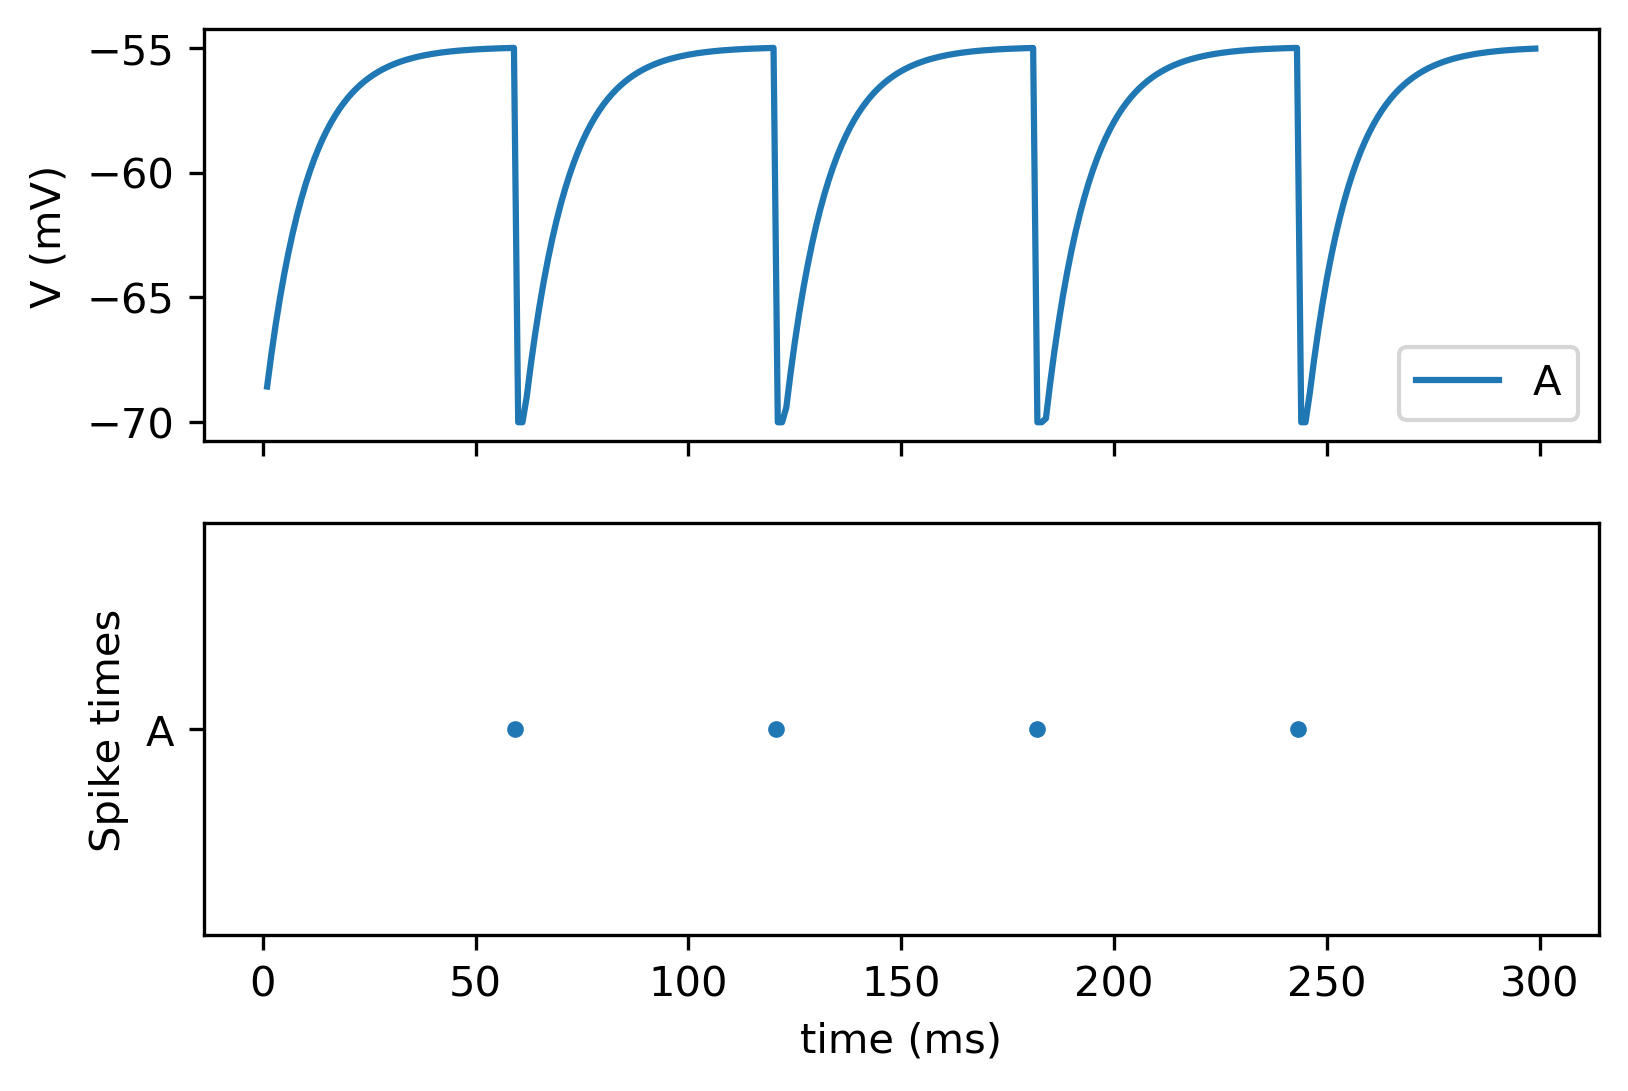

In [89]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# reset kernel for new example

nest.ResetKernel()

neuron_A = nest.Create("iaf_psc_delta", 1, {"I_e": 376.0})

multimeter_A = nest.Create("multimeter", params={"withtime": True, "record_from":["V_m"]})
spikedetector_A = nest.Create("spike_detector", params={"withgid": True, "withtime": True})

nest.Connect(multimeter_A, neuron_A)
nest.Connect(neuron_A, spikedetector_A)

nest.Simulate(300.0)

# plot membrane potential and spiking activity

plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)

multimeter_A_readout = nest.GetStatus(multimeter_A)[0]
V_A = multimeter_A_readout["events"]["V_m"]
t_A = multimeter_A_readout["events"]["times"]

spikedetector_A_readout = nest.GetStatus(spikedetector_A, keys="events")[0]
event_A = spikedetector_A_readout["senders"]
te_A = spikedetector_A_readout["times"]

ax[0].set_ylabel('V (mV)')

ax[0].plot(t_A, V_A, color="tab:blue", label="A")
ax[0].legend()   

ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('Spike times')
ax[1].plot(te_A, event_A, ".")

ax[1].set_yticks([1])
ax[1].set_yticklabels(["A"])

plt.show()

Now let's create neuron B as `iaf_psc_delta` with no external current:

In [98]:
neuron_B = nest.Create("iaf_psc_delta", 1, {"I_e": 300.0})

multimeter_B = nest.Create("multimeter", params={"withtime": True, "record_from":["V_m"]})
spikedetector_B = nest.Create("spike_detector", params={"withgid": True, "withtime": True})

nest.Connect(multimeter_B, neuron_B)
nest.Connect(neuron_B, spikedetector_B)


We'll use the function below to easily plot the activity of the two neurons at the same time:

In [99]:
def plot2neurons(multimeter_A, multimeter_B, spikedetector_A, spikedetector_B):
    multimeter_A_readout = nest.GetStatus(multimeter_A)[0]
    V_A = multimeter_A_readout["events"]["V_m"]
    t_A = multimeter_A_readout["events"]["times"]

    multimeter_B_readout = nest.GetStatus(multimeter_B)[0]
    V_B = multimeter_B_readout["events"]["V_m"]
    t_B = multimeter_B_readout["events"]["times"]
    
    spikedetector_A_readout = nest.GetStatus(spikedetector_A, keys="events")[0]
    event_A = spikedetector_A_readout["senders"]
    te_A = spikedetector_A_readout["times"]

    spikedetector_B_readout = nest.GetStatus(spikedetector_B, keys="events")[0]
    event_B = spikedetector_B_readout["senders"]
    te_B = spikedetector_B_readout["times"]        

    plt.rcParams['figure.dpi'] = 300
    fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)    
    
    ax[0].set_ylabel('V (mV)')
    
    ax[0].plot(t_A, V_A, color="tab:blue", label="A")
    ax[0].plot(t_B, V_B, color="tab:orange", label="B")
    ax[0].legend()
    
    ax[1].set_ylim(0,5)
    ax[1].set_yticks([1,4])
    ax[1].set_yticklabels(["A","B"])
    ax[1].set_xlabel('time (ms)')
    ax[1].set_ylabel('Spike times')

    ax[1].plot(te_A, event_A, ".", color="tab:blue")
    ax[1].plot(te_B, event_B, ".", color="tab:orange")

    plt.show()

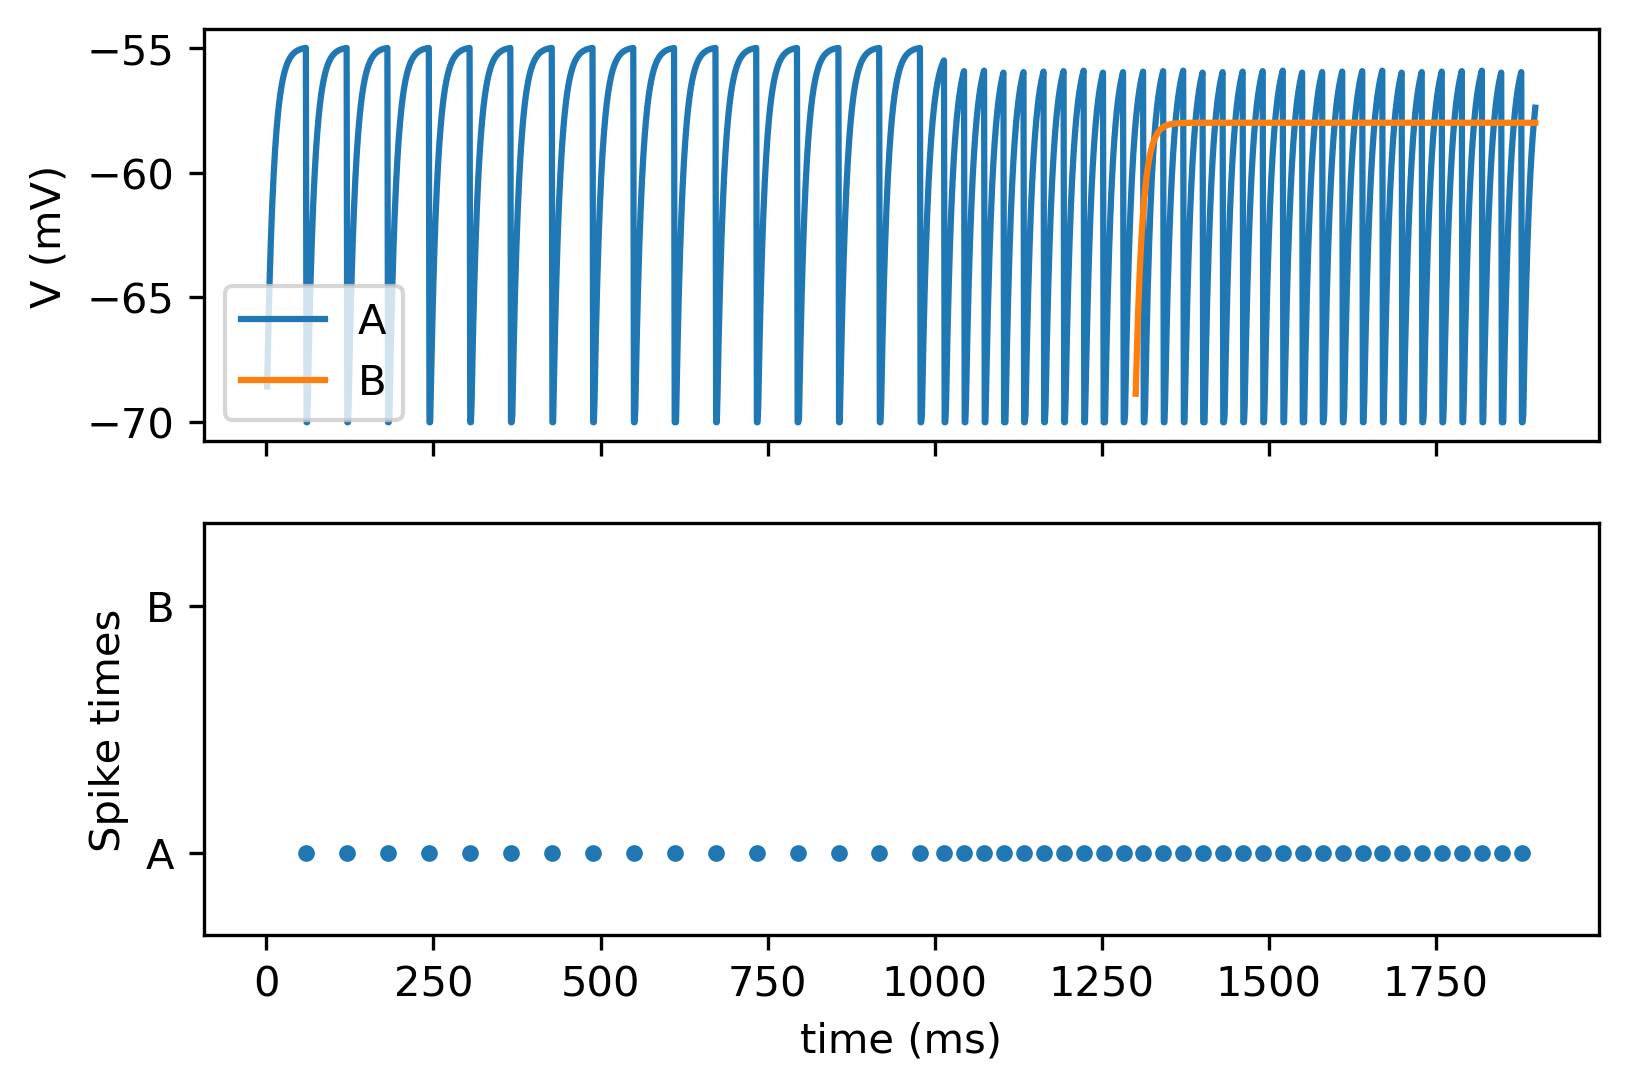

In [101]:
nest.Simulate(300.0)
plot2neurons(multimeter_A, multimeter_B, spikedetector_A, spikedetector_B)

Neuron B is still inactive. We need to connect both neurons:

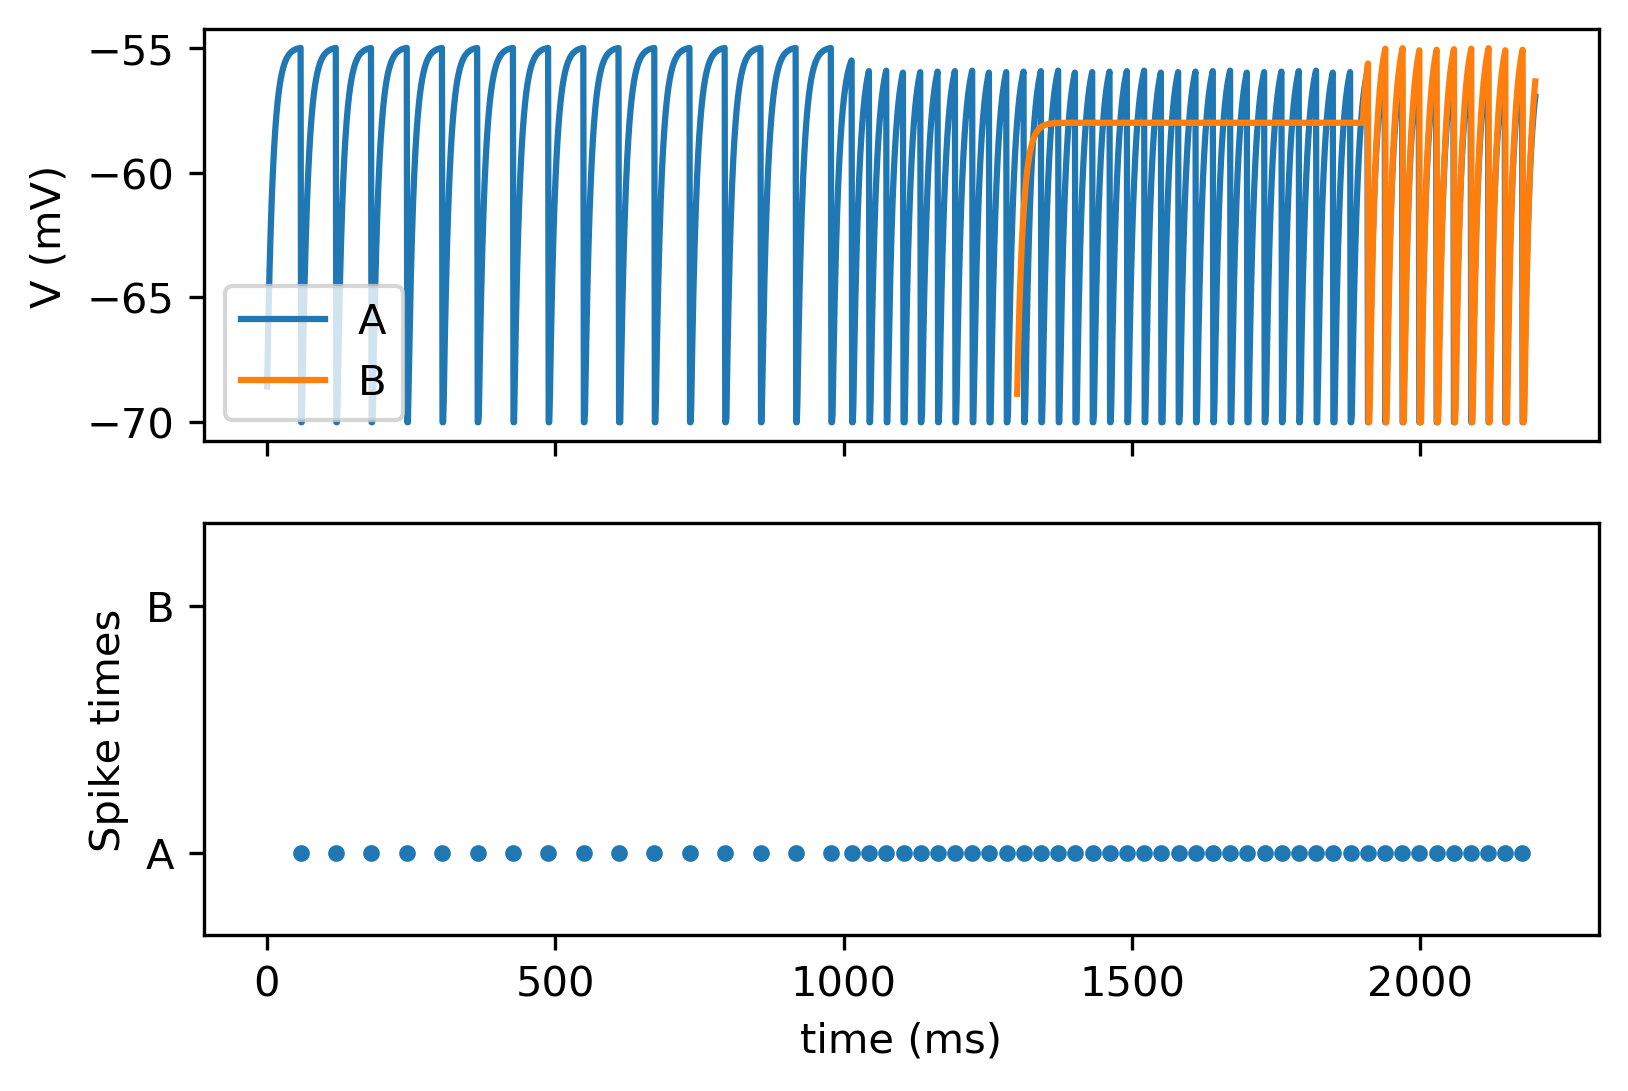

In [102]:
nest.Connect(neuron_A, neuron_B, {"rule": "one_to_one"}, {"model": "static_synapse"})
nest.Connect(neuron_B, neuron_A, {"rule": "one_to_one"}, {"model": "static_synapse", "weight": 1.})

neuron_B = nest.SetStatus(neuron_B, params={"I_e": 400.0})
nest.Simulate(300.0)
plot2neurons(multimeter_A, multimeter_B, spikedetector_A, spikedetector_B)

### Suggest at least 3 alterations we can make in this example to elicit spiking activity from B.

Run the code below and check if B spikes using the spike time raster (bottommost graph). 

Additionally, check what happens if the neuron model is different: for example, change `iaf_psc_delta` to `hh_psc_alpha`.

Finally, connect B to A reciprocally and check their dynamics. How can you describe their behavior?

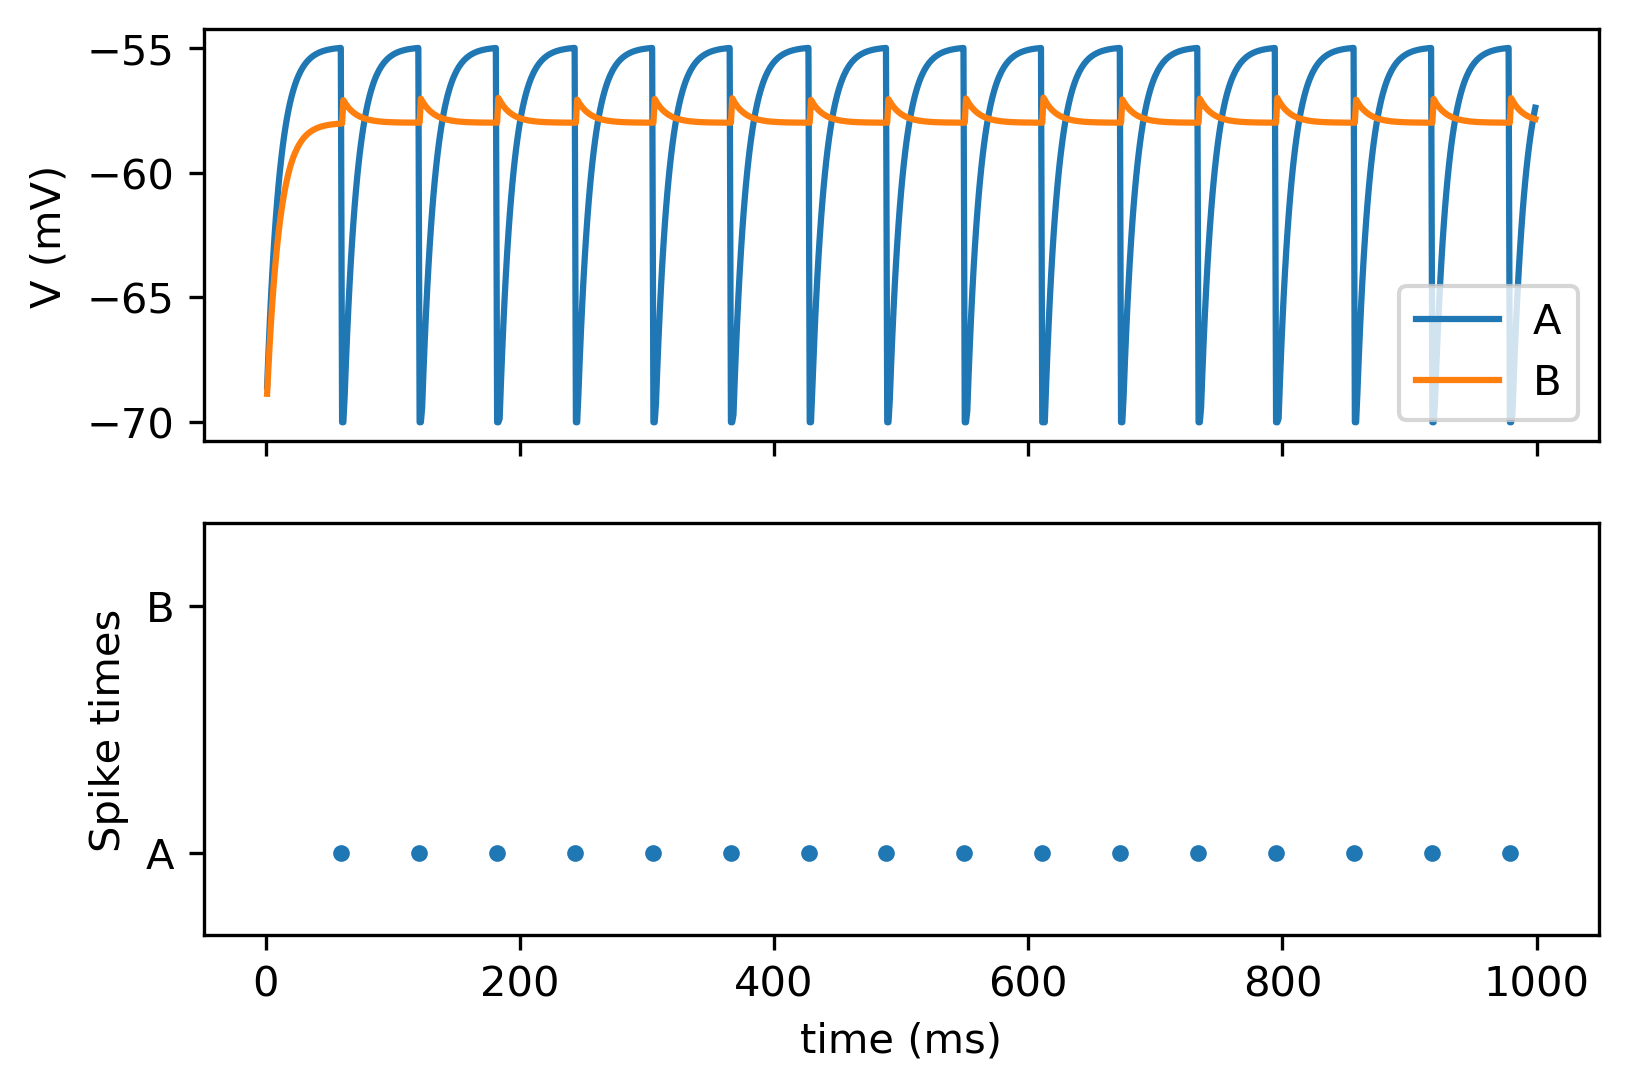

In [96]:
nest.ResetKernel()

neuron_A = nest.Create("iaf_psc_delta", 1, {"I_e": 376.0})

multimeter_A = nest.Create("multimeter", params={"withtime": True, "record_from":["V_m"]})
spikedetector_A = nest.Create("spike_detector", params={"withgid": True, "withtime": True})

nest.Connect(multimeter_A, neuron_A)
nest.Connect(neuron_A, spikedetector_A)

neuron_B = nest.Create("iaf_psc_delta", 1, {"I_e": 300.0})

multimeter_B = nest.Create("multimeter", params={"withtime": True, "record_from":["V_m"]})
spikedetector_B = nest.Create("spike_detector", params={"withgid": True, "withtime": True})

nest.Connect(multimeter_B, neuron_B)
nest.Connect(neuron_B, spikedetector_B)

nest.Connect(neuron_A, neuron_B, {"rule": "one_to_one"}, {"model": "static_synapse", "weight": 1.})

nest.Simulate(1000.0)
plot2neurons(multimeter_A, multimeter_B, spikedetector_A, spikedetector_B)